From https://www.youtube.com/watch?v=tPYj3fFJGjk from 00:00:00 to 1:54:56

This tutorial covers tensorflow this is part 1

In [1]:
import tensorflow as tf

In [2]:
string = tf.Variable('this is a string', tf.string)
number = tf.Variable(324, tf.int16)
floating = tf.Variable(5.28, tf.float64)

In [3]:
rank1_tensor = tf.Variable(['Test', 'Hello'])
rank2_tensor = tf.Variable([['test', 'ok',], ['hello', 'yes'], ['hello', 'why']])
print(rank2_tensor)
tf.rank(rank2_tensor)

<tf.Variable 'Variable:0' shape=(3, 2) dtype=string, numpy=
array([[b'test', b'ok'],
       [b'hello', b'yes'],
       [b'hello', b'why']], dtype=object)>


<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [4]:
rank2_tensor.shape

TensorShape([3, 2])

Note: the -1 in the reshape will auto fill the tensor into whatever shape will fit the elements. You can only use one -1 modifier at a time. Impossible shapes will throw an error

In [5]:
t1 = tf.ones([1,2,3])
t2 = tf.reshape(t1, [2,3,1])
t3 = tf.reshape(t2, [3,-1])

In [7]:
with tf.Session() as sess:
    t3.eval()
#Can't make this work, maybe obsolete?

AttributeError: module 'tensorflow' has no attribute 'Session'

In [ ]:
t = tf.zeros([5,5,5,5])
t = tf.reshape(t,[-1])

New section

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc 



In [ ]:
dftrain = pd.read_csv('train.csv')
dfeval = pd.read_csv('eval.csv')
ytrain = dftrain.pop('survived')
yeval = dfeval.pop('survived')

Initial data exploration

In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
dftrain.shape

(627, 9)

<AxesSubplot: >

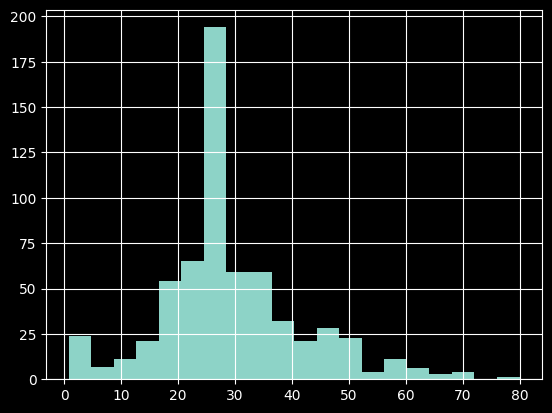

In [ ]:
dftrain.age.hist(bins= 20)

In [ ]:
dftrain.sex.value_counts().plot(kind = 'barh')

In [ ]:
dftrain['class'].value_counts().plot(kind = 'barh')

Text(0, 0.5, '% survive')

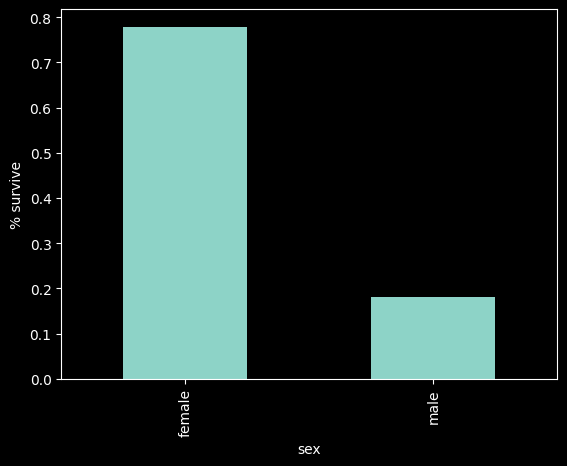

In [ ]:
pd.concat([dftrain,ytrain], axis = 1).groupby('sex').survived.mean().plot(kind = 'bar').set_ylabel('% survive')

In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique() # gets a list of unique values from given columns
    
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float32))

print(feature_columns)


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [ ]:
dftrain['embark_town'].unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

Input function: taken from tf documentation. It converts our pandas dataframe into a tf.data.Dataset object

In [ ]:
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
    #data_df is the dataframe without the desired output, label df is the dataframe with the desired output
    # num_epochs is number of times the dataset is passed through/repeated, shuffle determines if the data is ramdomized before a new epoch
    # batch_size is number of data instances passed through at once
    # Remember: to avoid overfitting start with small epoch as move upwards 
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) #creates the tf.data.Dataset object with data and desired output(label)
        if shuffle:
            ds = ds.shuffle(1000) #this shuffles the initial data set provided its size is under 1000. Note that by default this will also shuffle any epochs created using the repeat method, this can be changed with the arg reshuffle_each_iteration=False
        ds = ds.batch(batch_size).repeat(num_epochs) # splits data into batches of 32 and repeats for number of epochs
        return ds #returns a batch of the dataset
    return input_function # returns the function object to whereever it is called from, and will pass the arguments to it


In [ ]:
train_input_fn = make_input_fn(dftrain, ytrain, num_epochs= 10)
eval_input_fn = make_input_fn(dfeval, yeval, num_epochs=1, shuffle = False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)

result = linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Patrick\\AppData\\Local\\Temp\\tmp5dr2we22', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read

In [ ]:
print(result['accuracy']) # This accuracy is done using the labeled result

0.7651515


In [ ]:
print(result)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.8128252, 'auc_precision_recall': 0.7673795, 'average_loss': 0.5208784, 'label/mean': 0.375, 'loss': 0.5107861, 'precision': 0.72839504, 'prediction/mean': 0.30854413, 'recall': 0.5959596, 'global_step': 200}


Using the model to look at specific predictions

In [ ]:
result = list(linear_est.predict(eval_input_fn))
clear_output()
print(result[0]['probabilities'][1]) #This give probability of survival for the first person, [0] gives probability of death
print(result[0]) #This gives us information about the first prediction
print(dfeval.loc[0]) #This gives information about the first person
print(yeval[0]) #This gives the correct labeled answer

0.06743658
{'logits': array([-2.6267495], dtype=float32), 'logistic': array([0.06743658], dtype=float32), 'probabilities': array([0.9325635 , 0.06743658], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1]), 'all_classes': array([b'0', b'1'], dtype=object)}
sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0


The following is some dummy data I created to test the model and see how it reacted to different values

In [ ]:
xcheck = pd.read_csv('Test Data.csv')
xtrue = xcheck.pop('survived')
testeval = make_input_fn(xcheck, xtrue, num_epochs=1, shuffle=False)
checking = list(linear_est.predict(testeval))
print(checking[0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Patrick\AppData\Local\Temp\tmp5dr2we22\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([0.8175309], dtype=float32), 'logistic': array([0.693712], dtype=float32), 'probabilities': array([0.30628806, 0.693712  ], dtype=float32), 'class_ids': array([1], dtype=int64), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1]), 'all_classes': array([b'0', b'1'], dtype=object)}
